#Titanic Data Analysis

##1. Introduction
RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning of 15 April 1912, 
after colliding with an iceberg during her maiden voyage from Southampton to New York City. 
Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making it one of the deadliest commercial 
peacetime maritime disasters in modern history. 

We have a sample dataset that contains demographics and passenger information from 891 of the 2224 passengers and 
crew on board the Titanic. 
Description of datafields can be found at (https://www.kaggle.com/c/titanic/data)

##2. Questions
My intuition is that gender and age might have played a role in determining survival. In any case, it would be worthwhile to look at these aspects. Also, the passenger class is also worth looking at. It's quite possible that the elite would have more security procedures in place. As such, I will be exploring the following questions - 

* Which gender had better survival chance?
* Had social class any impact on survival?
* Did any age group had better chance of survival?
* What about the survival rate of children, women and men?

I will start by loading the sample data in pandas dataframe. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Render plots inline
%matplotlib inline

# read file and create dataframe
filename = 'titanic-data.csv'
titanic_data = pd.read_csv(filename)

#print sample records
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
#number of missing values for each column
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

So we can see that around 80% of cabin information is missing. Although we don't need Cabin data to answer any of our above questions but let's see for each social class how many people having cabins survived.

Pclass  Survived
1       0            59
        1           117
2       0             3
        1            13
3       0             6
        1             6
dtype: int64


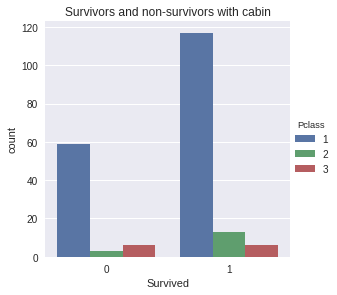

In [3]:
#survival status of people having cabin
non_missing_cabin = titanic_data[titanic_data.Cabin.notnull()]
sns.factorplot('Survived', hue='Pclass', data = non_missing_cabin, kind='count')
sns.plt.title('Survivors and non-survivors with cabin')
groupedby_class_survived_size = non_missing_cabin.groupby(['Pclass','Survived']).size()
print groupedby_class_survived_size

Seems like first class people had more cabins as compared to other class. But this doesn't tell much whether having cabin had any effect on survival as most of cabin information is missing. We will ignore this column for further analysis.

We also see that around 20% of records have missing age. We will keep this in mind when analyzing age.


In [4]:
# Determine number of males and females with missing age values
total_missing_age = pd.isnull(titanic_data['Age'])
missing_age_female = titanic_data[total_missing_age]['Sex'] == 'female'
missing_age_male = titanic_data[total_missing_age]['Sex'] == 'male'

print 'Number for females and males with age missing are {} and {} respectively'.format(missing_age_female.sum(),missing_age_male.sum())

Number for females and males with age missing are 53 and 124 respectively


In [5]:
#basic information about the data
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


##3. Data Wrangling

There are some columns in the dataset which are not much helpful in finding the answers. I will drop following columns from my dataset.
* Fare
* PassengerId
* Embarked
* Cabin
* Ticket
* Name


In [6]:
#drop unnecessary columns
titanic_data = titanic_data.drop(['PassengerId','Name','Ticket','Fare','Embarked','Cabin'],axis = 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


To increase the readability, I will modify **pclass** and **Survived** columns as follows.

 * pclass - 1 -> upper, 2 -> middle, 3 -> lower
 
 * Survived - 0 -> False, 1 -> True

In [7]:
#mapping social class values
def conv_class(pclass):
    if pclass == 1:
        return 'Upper'
    elif pclass == 2:
        return 'Middle'
    else:
        return 'Lower'
    

#mapping survived status
def conv_survived_status(status):
    if status == 1:
        return 'True'
    else:
        return 'False'
    
titanic_data.loc[:,'Survived'] = titanic_data.loc[:,'Survived'].apply(conv_survived_status)
titanic_data.loc[:,'Pclass'] = titanic_data.loc[:,'Pclass'].apply(conv_class)

titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,False,Lower,male,22.0,1,0
1,True,Upper,female,38.0,1,0
2,True,Lower,female,26.0,0,0
3,True,Upper,female,35.0,1,0
4,False,Lower,male,35.0,0,0


##4. Data Exploration and Visualization

###4.1 Number of Survivors and Non-Survivors

Total Records: 891 
Number of survivors: 549 
Number of non survivors: 342


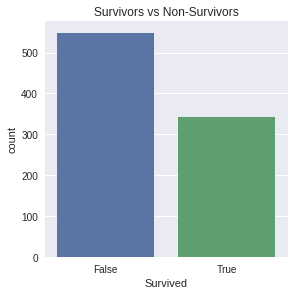

In [8]:
#Number of survivors and non-survivors
sns.factorplot('Survived',data = titanic_data, kind='count')
sns.plt.title('Survivors vs Non-Survivors')
survivors = len(titanic_data[titanic_data.Survived=='False'])
nonsurvivors = len(titanic_data[titanic_data.Survived=='True'])
total_rec = len(titanic_data)
print 'Total Records: {} \nNumber of survivors: {} \nNumber of non survivors: {}'.format(total_rec, survivors, nonsurvivors)

###4.2 Which gender had better survival chance?

Let's first see how many males and females were on ship and who survived more.

Survived  False  True
Sex                  
female       81   233
male        468   109


Proportion of survivors and non-survivors by gender

Survived     False      True
Sex                         
female    0.147541  0.681287
male      0.852459  0.318713


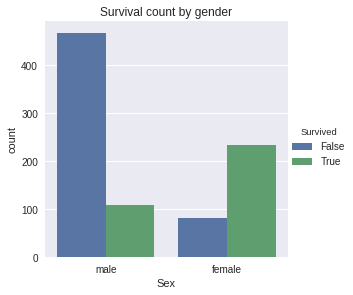

In [9]:
#survival rate by gender
sns.factorplot('Sex',hue='Survived', data = titanic_data, kind='count')
sns.plt.title('Survival count by gender')
tot_gender = pd.crosstab(titanic_data['Sex'], titanic_data['Survived'])
print tot_gender

print '\n'
print 'Proportion of survivors and non-survivors by gender\n'
colsum = tot_gender.sum(axis = 0)
colpct = tot_gender/colsum

print colpct


Above graph shows that although there were more males than females but still survival rate for females was high. 

But to see whether gender actually had any impact on survival, let's perform a chi-square test.

**Hypothesis:**

Ho : Gender had no affect on survival rate

HA : Gender had affect on survival rate

Here gender is independent variable and survival status dependent variable.

In [10]:
#chi-square test on gender
chi_gender = pd.crosstab(titanic_data['Sex'], titanic_data['Survived'])
chi_g, p_g, dof_g, expected_g = stats.chi2_contingency(chi_gender.values)
phi_gen = np.sqrt(chi_g/len(titanic_data))

results = [
    ['Item','Value'],
    ['Chi-Square Test',round(chi_g,6)],
    ['P-Value', round(p_g,2)],
    ['corr',round(phi_gen,6)]
]
results

[['Item', 'Value'],
 ['Chi-Square Test', 260.71702],
 ['P-Value', 0.0],
 ['corr', 0.540936]]

here p < 0.05 thus we can reject our null hypothesis and we can say that gender had high impact on survival rate. And as our graph also confirms the result we can say that female have survived more as compared to men.

###4.3 Had social class any impact on survival?

Survived  False  True
Pclass               
Lower       372   119
Middle       97    87
Upper        80   136


Proportion of survivors and non-survivors by class

Survived     False      True
Pclass                      
Lower     0.677596  0.347953
Middle    0.176685  0.254386
Upper     0.145719  0.397661


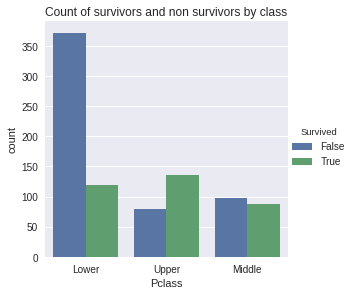

In [11]:
#survival by class
sns.factorplot('Pclass',hue='Survived', data = titanic_data, kind='count')
sns.plt.title('Count of survivors and non survivors by class')

pclass = pd.crosstab(titanic_data['Pclass'], titanic_data['Survived'])
print pclass

print '\n'
print 'Proportion of survivors and non-survivors by class\n'
colsum = pclass.sum(axis = 0)
colpct = pclass/colsum

print colpct

From above graph we see that maximum number of people belonged to lower class but survival rate for upper class people is  higher then other middle and lower class people.

Pclass  Survived  Sex   
Lower   False     female     72
                  male      300
        True      female     72
                  male       47
Middle  False     female      6
                  male       91
        True      female     70
                  male       17
Upper   False     female      3
                  male       77
        True      female     91
                  male       45
dtype: int64


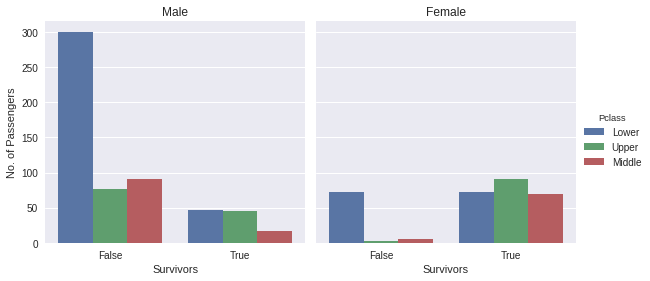

In [12]:
#survival by class and gender

# count of passengers by survival, group and sex
groupedby_class_survived_size = titanic_data.groupby(['Pclass','Survived','Sex']).size()

# Print - Grouped by class, survival and sex
print groupedby_class_survived_size

# Graph - Grouped by class, survival and sex
g = sns.factorplot('Survived', col='Sex', hue='Pclass', data=titanic_data, kind='count')

# Fix up the labels
(g.set_axis_labels('Survivors', 'No. of Passengers')
    .set_xticklabels(["False", "True"])
    .set_titles('{col_name}')
)

titles = ['Male', 'Female']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


Above plots shows that survival rate for females is higher than survival rate of men for each class type.

Now let's see whether class level had really any impact on survival.

Hypothesis

Ho : Class had no affect on survival rate

HA : Class had affect on survival rate

Here Class is independent variable and survival status dependent variable.

In [13]:
#Chi-square test on class type
chi_class = pd.crosstab(titanic_data['Survived'], titanic_data['Pclass'])
chi_cl, p_cl, dof_cl, expected_cl = stats.chi2_contingency(chi_class.values)
phi_cl = np.sqrt(chi_cl/len(titanic_data))

results = [
    ['Item','Value'],
    ['Chi-Square Test',round(chi_cl,6)],
    ['P-Value', round(p_cl,6)],
    ['corr',round(phi_cl,6)]
]
results

[['Item', 'Value'],
 ['Chi-Square Test', 102.888989],
 ['P-Value', 0.0],
 ['corr', 0.339817]]

As the P-Value is less than 0.05 the probability of that the social class will impact the chances of survival is high. Therefore we can reject the null hypothesis.

###4.4 Did any age group had better chance of survival?

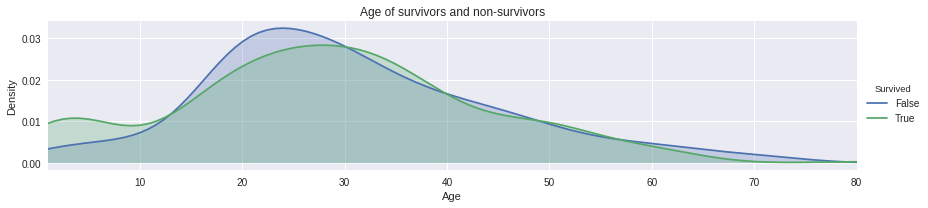

In [16]:
#Age of survivors and non-survivors
fig = sns.FacetGrid(titanic_data, hue='Survived', aspect=4)
sns.plt.title('Age of survivors and non-survivors')
fig.map(sns.kdeplot, 'Age', shade=True)
oldest = titanic_data['Age'].max()
fig.set(xlim=(1, oldest))
fig.add_legend()
plt.ylabel('Density')

From the graph we see that most of the people on ship were between the age of 20 and 30. This graph doesn't include the records with the missing age.

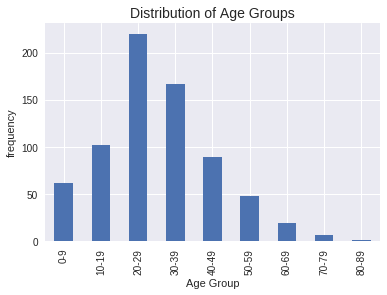

In [17]:
#Adding age group
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79','80-89']
titanic_data['age_group'] = pd.cut(titanic_data.Age, range(0, 91, 10), right=False, labels=age_labels)
titanic_data.groupby(['age_group']).size().plot(kind='bar',stacked=True)
plt.title("Distribution of Age Groups",fontsize=14)
plt.ylabel('frequency')
plt.xlabel('Age Group')

In [18]:
#chi-square test on age group
chi_agegp = pd.crosstab(titanic_data['Survived'], titanic_data['age_group'])
chi_age, p_age, dof_age, expected_age = stats.chi2_contingency(chi_agegp.values)
phi_age = np.sqrt(chi_age/len(titanic_data))

results = [
    ['Item','Value'],
    ['Chi-Square Test',round(chi_age,6)],
    ['P-Value', round(p_age,6)],
    ['corr',round(phi_age,6)]
]
results

[['Item', 'Value'],
 ['Chi-Square Test', 20.981463],
 ['P-Value', 0.007197],
 ['corr', 0.153454]]

As the P-Value is less than 0.05 we can say age had some impact on survival rate and we can reject our null hypothesis.

###4.5 What about the survival rate of children, women and men?

In [19]:
#Categorizing Child or woman vs man
def ischild(category):
    if (category['Age'] <= 14):
        return 'child'
    elif (category['Sex'] == 'female'):
        return 'woman'
    else:
        return 'man'

titanic_data.loc[:,'Person'] = titanic_data.apply(ischild,axis = 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,age_group,Person
0,False,Lower,male,22.0,1,0,20-29,man
1,True,Upper,female,38.0,1,0,30-39,woman
2,True,Lower,female,26.0,0,0,20-29,woman
3,True,Upper,female,35.0,1,0,30-39,woman
4,False,Lower,male,35.0,0,0,30-39,man


Pclass  Person
Lower   child      53
        man       320
        woman     118
Middle  child      19
        man        99
        woman      66
Upper   child       5
        man       119
        woman      92
dtype: int64

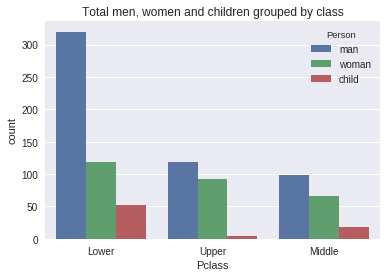

In [20]:
#Totals grouped by men, women and children and by class
sns.countplot(x="Pclass", hue="Person", data=titanic_data)
sns.plt.title('Total men, women and children grouped by class')
groupedby_personclass = titanic_data.groupby(['Pclass','Person']).size()
groupedby_personclass

Person    child  man  woman
Survived                   
False        32  450     67
True         45   88    209


Person       child       man     woman
Survived                              
False     0.415584  0.836431  0.242754
True      0.584416  0.163569  0.757246


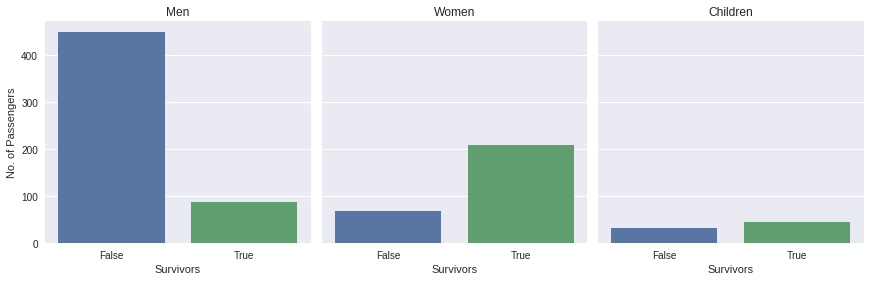

In [21]:
# Get the totals grouped by Men, Women and Children, and by survival
person_perc = pd.crosstab(titanic_data['Survived'], titanic_data['Person'])
print person_perc
print '\n'

#Get proportion grouped Men, Women and Children, and by survival
colsum = person_perc.sum(axis = 0)
colpct = person_perc/colsum
print colpct

# Graph - Compare survival count between Men, Women and Children
g = sns.factorplot('Survived', col='Person', data=titanic_data, kind='count')

# Fix up the labels
g.set_axis_labels('Survivors', 'No. of Passengers')

#Ttiles for graphs
titles = ['Men', 'Women', 'Children']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

The plot shows that women survival rate was high as compared to men. But a point worth noting is that the children survival rate is not as high as expected.

###4.6 Survivors with and without family

In [22]:
#adding column that tells whether person was with family or not
def isalone(family):
    if((family['Parch'] == 0) & (family['SibSp'] == 0)):
        return 'True'
    else:
        return 'False'
    
titanic_data.loc[:,'isalone'] = titanic_data.apply(isalone,axis = 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,age_group,Person,isalone
0,False,Lower,male,22.0,1,0,20-29,man,False
1,True,Upper,female,38.0,1,0,30-39,woman,False
2,True,Lower,female,26.0,0,0,20-29,woman,True
3,True,Upper,female,35.0,1,0,30-39,woman,False
4,False,Lower,male,35.0,0,0,30-39,man,True


isalone   False  True
Survived             
False       175   374
True        179   163


isalone     False      True
Survived                   
False     0.49435  0.696462
True      0.50565  0.303538


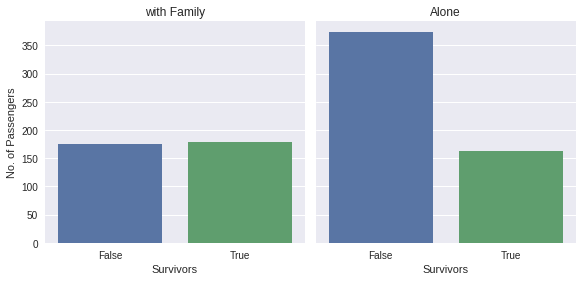

In [23]:
#get totals grouped by islone status and survival
alone_perc = pd.crosstab(titanic_data['Survived'], titanic_data['isalone'])
print alone_perc

print '\n'
colsum = alone_perc.sum(axis = 0)
colpct = alone_perc/colsum

print colpct

# Graph - survival count of person with and without family
g = sns.factorplot('Survived', col='isalone', data=titanic_data, kind='count')
# Fix up the labels
g.set_axis_labels('Survivors', 'No. of Passengers')
#Fix up titles
titles = ['with Family', 'Alone']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

There is not a major difference between survival rate of people with ot without family

##6. Conclusion

The results of the analysis appears to indicate that overall population of males was quite high on ship but still survival rate for female was more. Upper class people had high survival chance as compared to lower and middle class people. Age also had some impact on survival rate.

##7. References

http://changingminds.org/explanations/research/analysis/chi-square.htm

http://changingminds.org/explanations/research/analysis/phi.htm

http://learntech.uwe.ac.uk/da/Default.aspx?pageid=1440

http://www.people.vcu.edu/~pdattalo/702SuppRead/MeasAssoc/NominalAssoc.html

https://cyfar.org/types-statistical-tests